In [30]:
#  import main packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import shap

# define variables
immo_vis_dir = "../../data/immo_vis/"
parquet_extension = ".parquet"
compression_extension = ".gz"

metropole_appartement_file = "ventes-metropole-appartement" + parquet_extension
metropole_appartement_file_cleaned = metropole_appartement_file + "_V1_clean_" + parquet_extension

acp_appartement_file = "df_ACP_IRIS_immo_Processed"  + parquet_extension

app_model_data_file = "ventes-metropole-model-appartement" 
app_model_data_X_file = "ventes-metropole-model-appartement-X" 
app_model_data_Y_file = "ventes-metropole-model-appartement-Y" 
app_shap_explainer_file = "shap-explainer"
app_shap_values_file = "shap-values"


DROP_COLUMNS = ['prix_bien','date',"expo_double","CODE_IRIS"]

# set model option
SaveModelData = True
#  Set plot options
LargePlotActive = False
MediumPlotActive = False
SmallPlotActive = False
HeatMapDisplay = False

lgbRegressionON = False
XGBRegressorON = False
GridSearchXGBRegressor = False
GridSearchDecisionTree = False
XGBRegressorOpimizedON = True
DecisionTreeDisplay = True
ShapDisplay = True

DropRegDep = True
DropLoyer = True
AddACP = True

# # functions

In [37]:
# functions  
import joblib
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

import time

def print_numerical_isna(df) :
    columns = df.select_dtypes(include='number').columns.tolist()
    print (df[columns].isna().sum())

def print_categorial_isna(df) :
    columns = df.select_dtypes(include='category').columns.tolist()
    print (df[columns].isna().sum())     

def load_appartement_file (filename) :
    start_path = Path(immo_vis_dir)
    final_path = start_path / filename
    return pd.read_parquet(final_path.as_posix())

def save_model_file (model,filename,model_name,comp_ext="") :
    start_path = Path(immo_vis_dir)
    final_path = start_path / (filename + '-' +  model_name + comp_ext)
    print (f"save model filename {final_path.as_posix()}")
    if comp_ext == ".gz" :
        joblib.dump(model, final_path.as_posix(),compress=('gzip', 3))
    elif comp_ext == ".bz2" :
        joblib.dump(model, final_path.as_posix(),compress=('gzip', 3))
    else :
        joblib.dump(model, final_path.as_posix())
        
def load_model_file (filename) :
    start_path = Path(immo_vis_dir)
    final_path = start_path / filename
    return joblib.load(filename)

def save_image (plt, filename,modelname, dpi=150) :
    start_path = Path(immo_vis_dir)
    final_path = start_path / (filename+ '-' + modelname)
    plt.savefig(final_path.as_posix(), bbox_inches='tight')

def save_appartement_file (df, filename,drop_columns = None) :
    start_path = Path(immo_vis_dir)
    final_path = start_path / filename
    if drop_columns is None :
        df.to_parquet(path=final_path.as_posix(),index=True)
    else :
        df1 = df.drop(columns= drop_columns)
        df1.to_parquet(path=final_path.as_posix(),index=True)

def get_numerical_column_names (df) :
    return [ column for column  in df.columns if df[column].dtype not in ["object","category"]]

def apply_scale_processing(operator,X_train,X_test):
    #Operator could be scaler or encode
    op=operator
    op.fit(X_train)
    X_train_treated=pd.DataFrame(op.transform(X_train),columns=X_train.columns)
    X_test_treated=pd.DataFrame(op.transform(X_test),columns=X_train.columns)
    return X_train_treated,X_test_treated

def apply_preprocessing  (df, drop_columns,target_column, drop_region = True,drop_loyer=True) :
    y_tmp =df[target_column]
    columns = drop_columns
    columns.append(target_column)
    if drop_region :
        columns.append("DEP")
        columns.append("REG")
    if drop_loyer :
        columns.extend(['loyer_m2_median_n7', 'nb_log_n7', 'taux_rendement_n7'])

    X_tmp =df.drop(columns=columns)
    return X_tmp,y_tmp

def create_train_test_data (X ,y) :
    from sklearn.model_selection import train_test_split
    #  build the train and test data
    print (X.shape)
    return train_test_split(X,y,test_size=0.2,random_state=42)

def create_train_test_data_subset (X ,y,subset_size = 1.0) :
    from sklearn.model_selection import train_test_split
    #  build the train and test data
    print (X.shape)
    return train_test_split(X,y,test_size=0.2,train_size=subset_size, random_state=42)

# # decode file and display infos

In [3]:
# import appartement file

df_processed= load_appartement_file(metropole_appartement_file_cleaned)
nb_rows= df_processed.shape[0]
nb_cols= df_processed.shape[1]

In [4]:
#  print main infos on appartmeent file

print ( f" {metropole_appartement_file_cleaned} rows {nb_rows} columns {nb_cols}")
print (df_processed.info())



 ventes-metropole-appartement.parquet_V1_clean_.parquet rows 2077476 columns 49
<class 'pandas.core.frame.DataFrame'>
Index: 2077476 entries, immo-facile-57743459 to 134327817
Data columns (total 49 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   etage                    int64         
 1   surface                  int64         
 2   nb_pieces                int64         
 3   prix_bien                int64         
 4   balcon                   int64         
 5   eau                      int64         
 6   bain                     int64         
 7   annonce_exclusive        int64         
 8   nb_etages                float64       
 9   places_parking           float64       
 10  cave                     int64         
 11  annee_construction       float64       
 12  nb_toilettes             int64         
 13  nb_terraces              float64       
 14  videophone               int64         
 15  porte_digicode       

In [5]:
ACPS0 = {"PC1": "1 Urbain dense / Rural isolé",
        "PC2" : "2 Péri urbain résidentiel / villes populaire ancien",
        "PC3" : "3 Diplômés Centre ville / populaire ouvrier",
        "PC4" : "4 Seniors stations balnéaires / récents et modestes",
        "PC5" : "5 logements récents croissance / résidentiel ancien",
        "PC6" : "6 Délinquance centre ville/ logement sociaux",
        "PC7" : "7 Drogue ville quartiers anciens / technopoles et campus",
        "PC8" : "8 Habitant ancien serré / ZAC et campus récents",
        "PC9" : "9 Délits cambriolage vols / Stupéfiants petites villes",
        "PC10" : "10 petites communs actives / viellissantes",
        "PC11" : "11 territoires ruraux agricoles / urbain en déclin",
        "PC12" : "12 petites communes autonomes / agglomération",
        "PC13" : "13 Communes du litoral",
        "PC14" : "14 Villages touristiques anciens,habitat collectif",
        "PC15" : "PC15",
        "PC16" : "PC16",
        "PC17" : "PC17",
        "PC18" : "PC18",
        "PC19" : "PC19",
        "PC20" : "PC20",
        "CODE_IRIS" : "CODE_IRIS"
       }

ACPS1 = {"PC1": "1 Rural isolé  + Urbain dense",
        "PC2" : "2 Terr déclinant Vs Résidentiel récent aisé",
        "PC3" : "3 - Ouvrier Populaire + Diplômé Centre ville",
        "PC4" : "4 - Récent et modeste + Senior station balnéaire",
        "PC5" : "5 - Résidentiel ancien + logement récent croissance",
        "PC6" : "6 Délinquance - Logement social + centre ville",
        "PC7" : "7 Drogue - technopole et campus + ville quartier ancien",
        "PC8" : "8 - ZAC et campus récents + Habitant ancien serré",
        "PC9" : "9 - Stupéfiants petite ville + Délit cambriolage vol",
        "PC10" : "10 Petites communes - viellissantes + actives",
        "PC11" : "11 Territoire - urbain en déclin + rural agricole",
        "PC12" : "12 - Agglomération + petite commune autonome ",
        "PC13" : "13 + Communes du litoral",
        "PC14" : "14 - Habitat collectif + Village touristique ancien",
        "PC15" : "PC15",
        "PC16" : "PC16",
        "PC17" : "PC17",
        "PC18" : "PC18",
        "PC19" : "PC19",
        "PC20" : "PC20",
        "CODE_IRIS" : "CODE_IRIS"
       }
       
ACPS = {"PC1": "1 Rural isolé  Vs Urbain dense",
        "PC2" : "2 Terr. déclinant Vs Résidentiel récent aisé",
        "PC3" : "3 Populaire Vs Etudes Sup + centre ville",
        "PC4" : "4 Acifs modestes  Vs Seniors résid. mer",
        "PC5" : "5 Résidentiel ancré Vs Récent en croissance",
        "PC6" : "6 Social Aisé Vs Délinquance centre  Hub",
        "PC7" : "7 Technopole Univ Vs STUP quartiers sensibles",
        "PC8" : "8 ZAC campus récent Vs Habitat trad. containt",
        "PC9" : "9 Stup evenement Vs Vols zones transit",
        "PC10" : "10 Petites communes dynamiques Vs déclinantes",
        "PC11" : "11 Urbain en déclin Vs Agricole en dévpt",
        "PC12" : "12 Commune dépendante Agglo Vs Commune autonome",
        "PC13" : "13 Communes du litoral commercantes",
        "PC14" : "14 Infrast rurales Vs Village tourist. ancien",
        "PC15" : "PC15",
        "PC16" : "PC16",
        "PC17" : "PC17",
        "PC18" : "PC18",
        "PC19" : "PC19",
        "PC20" : "PC20",
        "CODE_IRIS" : "CODE_IRIS"
       }


# Decode ACP file 

In [6]:
if AddACP :
    df_iris = load_appartement_file(acp_appartement_file)
    nb_rows= df_iris.shape[0]
    nb_cols= df_iris.shape[1]

    print ( f" {acp_appartement_file} rows {nb_rows} columns {nb_cols}")

    df_iris = df_iris.rename(ACPS,axis=1)

    print(" df_iris nan values",df_iris.isna().sum().sum())


    #  chop data

    print (df_iris.info())

 df_ACP_IRIS_immo_Processed.parquet rows 46806 columns 21
 df_iris nan values 0
<class 'pandas.core.frame.DataFrame'>
Index: 46806 entries, 0 to 46805
Data columns (total 21 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   CODE_IRIS                                        46806 non-null  int64  
 1   1 Rural isolé  Vs Urbain dense                   46806 non-null  float64
 2   2 Terr. déclinant Vs Résidentiel récent aisé     46806 non-null  float64
 3   3 Populaire Vs Etudes Sup + centre ville         46806 non-null  float64
 4   4 Acifs modestes  Vs Seniors résid. mer          46806 non-null  float64
 5   5 Résidentiel ancré Vs Récent en croissance      46806 non-null  float64
 6   6 Social Aisé Vs Délinquance centre  Hub         46806 non-null  float64
 7   7 Technopole Univ Vs STUP quartiers sensibles    46806 non-null  float64
 8   8 ZAC campus récent Vs Habitat 

# select the number of ACP to keep

In [7]:
if AddACP :
    keep_acp = 15
    acp_filter = list(range(0, keep_acp + 1))
    df_iris = df_iris.iloc[:,acp_filter]
    print (df_iris.info())
    display(df_iris)

<class 'pandas.core.frame.DataFrame'>
Index: 46806 entries, 0 to 46805
Data columns (total 16 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   CODE_IRIS                                        46806 non-null  int64  
 1   1 Rural isolé  Vs Urbain dense                   46806 non-null  float64
 2   2 Terr. déclinant Vs Résidentiel récent aisé     46806 non-null  float64
 3   3 Populaire Vs Etudes Sup + centre ville         46806 non-null  float64
 4   4 Acifs modestes  Vs Seniors résid. mer          46806 non-null  float64
 5   5 Résidentiel ancré Vs Récent en croissance      46806 non-null  float64
 6   6 Social Aisé Vs Délinquance centre  Hub         46806 non-null  float64
 7   7 Technopole Univ Vs STUP quartiers sensibles    46806 non-null  float64
 8   8 ZAC campus récent Vs Habitat trad. containt    46806 non-null  float64
 9   9 Stup evenement Vs Vols zones tr

,CODE_IRIS,1 Rural isolé Vs Urbain dense,2 Terr. déclinant Vs Résidentiel récent aisé,3 Populaire Vs Etudes Sup + centre ville,4 Acifs modestes Vs Seniors résid. mer,5 Résidentiel ancré Vs Récent en croissance,6 Social Aisé Vs Délinquance centre Hub,7 Technopole Univ Vs STUP quartiers sensibles,8 ZAC campus récent Vs Habitat trad. containt,9 Stup evenement Vs Vols zones transit,10 Petites communes dynamiques Vs déclinantes,11 Urbain en déclin Vs Agricole en dévpt,12 Commune dépendante Agglo Vs Commune autonome,13 Communes du litoral commercantes,14 Infrast rurales Vs Village tourist. ancien,PC15
0,10010000,-2.36,2.29,-0.27,0.52,-1.03,-0.27,0.03,0.14,-0.08,0.27,-0.61,-0.43,0.23,-0.36,1.04
1,10020000,-3.90,1.27,2.35,-0.27,0.56,0.14,0.57,1.23,1.24,-0.55,1.08,-0.61,0.47,-1.22,-0.56
2,10040101,6.94,0.55,-0.85,-0.53,1.25,0.61,-2.41,-1.14,-0.77,1.41,-0.92,-1.17,-0.72,0.75,0.50
3,10040102,6.95,-1.30,-3.22,-0.48,0.95,0.45,-0.73,-1.56,1.22,0.15,-1.03,-1.21,-0.06,-0.33,0.84
4,10040201,6.34,-0.10,-2.81,0.64,2.00,0.87,-1.52,-0.80,1.09,-0.22,-1.27,-1.67,-0.71,-0.31,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46801,956800112,8.56,-3.51,-4.11,-3.73,-1.08,-2.18,3.42,0.77,0.38,-0.13,0.90,1.08,1.23,-0.16,0.50
46802,956800113,8.99,-0.71,-4.90,-5.23,2.63,-1.20,2.73,-0.97,1.11,-1.16,1.65,0.31,1.21,-0.76,-0.02
46803,956800114,9.57,-4.39,-4.55,-4.01,-1.36,-2.74,4.11,0.91,1.06,-0.73,0.28,0.88,0.53,-0.20,0.31
46804,956820000,-0.89,2.98,0.71,-2.13,-0.34,-0.26,-0.35,2.11,-0.38,-0.62,-1.12,-0.58,0.05,0.31,-0.78


# Merge Data and ACP

In [8]:
if AddACP :
    df=df_processed.merge(df_iris,how='left',on='CODE_IRIS')
    df.info(show_counts=True)
    df = df.fillna(0)
    print("df merged isna() ", df.isna().sum().sum())
    print(df.shape)
    display(df)
else :
    df=df_processed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077476 entries, 0 to 2077475
Data columns (total 64 columns):
 #   Column                                           Non-Null Count    Dtype         
---  ------                                           --------------    -----         
 0   etage                                            2077476 non-null  int64         
 1   surface                                          2077476 non-null  int64         
 2   nb_pieces                                        2077476 non-null  int64         
 3   prix_bien                                        2077476 non-null  int64         
 4   balcon                                           2077476 non-null  int64         
 5   eau                                              2077476 non-null  int64         
 6   bain                                             2077476 non-null  int64         
 7   annonce_exclusive                                2077476 non-null  int64         
 8   nb_etages   

,etage,surface,nb_pieces,prix_bien,balcon,eau,bain,annonce_exclusive,nb_etages,places_parking,...,6 Social Aisé Vs Délinquance centre Hub,7 Technopole Univ Vs STUP quartiers sensibles,8 ZAC campus récent Vs Habitat trad. containt,9 Stup evenement Vs Vols zones transit,10 Petites communes dynamiques Vs déclinantes,11 Urbain en déclin Vs Agricole en dévpt,12 Commune dépendante Agglo Vs Commune autonome,13 Communes du litoral commercantes,14 Infrast rurales Vs Village tourist. ancien,PC15
0,0,65,2,136000,0,0,0,1,4.0,3.0,...,1.37,-0.04,0.03,1.43,0.64,-0.42,0.58,0.38,-0.29,0.02
1,1,72,3,369000,0,0,1,0,3.0,2.0,...,0.20,1.27,-0.32,2.05,-0.12,-0.64,-1.53,-0.38,-0.78,0.66
2,2,128,5,440000,1,1,1,0,3.0,1.0,...,0.20,1.27,-0.32,2.05,-0.12,-0.64,-1.53,-0.38,-0.78,0.66
3,0,76,4,170000,0,1,0,0,4.0,2.0,...,0.84,-0.38,-1.52,1.37,0.22,-0.13,-0.27,-0.31,-0.13,0.10
4,0,84,3,449000,0,0,0,1,4.0,1.0,...,-1.68,2.92,-1.12,0.04,0.92,0.24,-2.29,-0.61,0.18,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077471,1,59,2,202419,0,1,0,2,4.0,0.0,...,1.62,-3.34,0.06,-0.37,0.23,0.33,-0.03,0.14,0.56,0.58
2077472,2,36,2,110000,0,1,0,2,4.0,0.0,...,1.62,-3.34,0.06,-0.37,0.23,0.33,-0.03,0.14,0.56,0.58
2077473,1,97,4,169500,0,0,1,2,4.0,0.0,...,1.54,-0.92,1.60,1.23,-0.49,-0.00,-0.03,-0.70,-0.09,0.25
2077474,1,132,5,315000,0,0,0,2,4.0,0.0,...,1.54,-0.92,1.60,1.23,-0.49,-0.00,-0.03,-0.70,-0.09,0.25


# 1st Model Encoding

In [9]:
# check dtypes
display(df.dtypes)
print("porte_digicode",df.porte_digicode.unique())
print("ascenceur",df.ascenseur.unique())
print("cave",df.ascenseur.unique())

etage                                                int64
surface                                              int64
nb_pieces                                            int64
prix_bien                                            int64
balcon                                               int64
                                                    ...   
11 Urbain en déclin Vs Agricole en dévpt           float64
12 Commune dépendante Agglo Vs Commune autonome    float64
13 Communes du litoral commercantes                float64
14 Infrast rurales Vs Village tourist. ancien      float64
PC15                                               float64
Length: 64, dtype: object

porte_digicode [0 1]
ascenceur [0 1]
cave [0 1]


# save data

In [10]:
if SaveModelData : 
    save_appartement_file (df, app_model_data_file,drop_columns=DROP_COLUMNS)

# # Preprocessing

In [ ]:
# set target and data
print (df.columns)
X,y = apply_preprocessing(df,drop_columns=DROP_COLUMNS, target_column= 'prix_m2_vente', drop_region=DropRegDep,drop_loyer=DropLoyer)
print (df.columns)

save_appartement_file (df, app_model_data_file,drop_columns=DROP_COLUMNS)


Index(['etage', 'surface', 'nb_pieces', 'prix_bien', 'balcon', 'eau', 'bain',
       'annonce_exclusive', 'nb_etages', 'places_parking', 'cave',
       'annee_construction', 'nb_toilettes', 'nb_terraces', 'videophone',
       'porte_digicode', 'ascenseur', 'nb_logements_copro', 'logement_neuf',
       'date', 'CODE_IRIS', 'REG', 'DEP', 'loyer_m2_median_n7', 'nb_log_n7',
       'taux_rendement_n7', 'prix_m2_vente', 'charges_copro_m2', 'dpeL_num',
       'ges_class_num', 'chauf_energy_gaz', 'chauf_energy_elec',
       'chauf_energy_bois', 'chauf_energy_fioul', 'chauf_sys_climatisation',
       'chauf_sys_pompe_chaleur', 'chauf_sys_convecteur',
       'chauf_sys_radiateur', 'chauf_sys_chaudiere', 'chauf_sys_sol',
       'chauf_sys_poele_bois', 'chauf_mode_individuel', 'chauf_mode_collectif',
       'chauf_mode_central', 'expo_has_nord', 'expo_has_sud', 'expo_has_est',
       'expo_has_ouest', 'expo_double', '1 Rural isolé  Vs Urbain dense',
       '2 Terr. déclinant Vs Résidentiel récent 

#  # create train test dataset

In [12]:
#  train test split
from sklearn.model_selection import train_test_split
#  build the train and test data

X_train, X_test, y_train, y_test = create_train_test_data(X,y)

(2077476, 54)


In [13]:
# apply min max scaler
from sklearn.preprocessing import MinMaxScaler

if lgbRegressionON :
    X_train_scaled,X_test_scaled=apply_scale_processing(MinMaxScaler(),X_train,X_test)



# # train ans predict models

In [22]:
def fit_train_models (models,X_train, y_train,X_test,y_test,model_file_name=None, comp_ext = "") :
    results = []
    for name, model in models.items():
        print(f"Entraînement de {name}...")
        
        # Mesurer le temps d'entraînement
        start_time = time.time()
        model.fit(X_train, y_train)
        fit_time = time.time() - start_time

        if model_file_name is not None :
           start_time = time.time()
           save_model_file(model,model_file_name,name,comp_ext)
           save_model_time = time.time() - start_time
           print(f"save model time {save_model_time}")
        
        # Mesurer le temps de prédiction
        start_time = time.time()
        y_pred = model.predict(X_test)
        predict_time = time.time() - start_time
        
        # Calculer les métriques
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Model': name,
            'RMSE': rmse,
            'R²': r2,
            'Fit_Time': f"{fit_time:.4f}s",
            'Predict_Time': f"{predict_time:.4f}s",
            'Total_Time': f"{fit_time + predict_time:.4f}s"
        })

    # Afficher les résultats
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('RMSE')


    return results_df


In [15]:

import lightgbm as lgb
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression, Ridge
from sklearn.svm import SVR, LinearSVR

# Liste des modèles à tester
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'ElasticNetCV': ElasticNetCV(),
    'LinearSVR': LinearSVR(),
    # 'SVR': SVR(),
    # 'Random Forest': RandomForestRegressor(n_estimators=20, random_state=42),
    'lgb' : lgb.LGBMRegressor(
                            objective='regression',
                            metric='rmse',
                            num_leaves=31,
                            learning_rate=0.05,
                            force_row_wise=True,
                            # feature_fraction=0.9,
                        )
}

# Tester chaque modèle avec mesure du temps
if lgbRegressionON :
    results = fit_train_models(models,X_train_scaled,y_train,X_test_scaled,y_test)

    # Afficher les résultats
    print(results)


In [16]:



# Liste des modèles à tester
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


models = {
    # 'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    'XGBRegressor' : XGBRegressor(n_estimators=100, random_state=42),
    'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=10, random_state=42),
#     'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=20, random_state=42),
#     'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
}

# Tester chaque modèle avec mesure du temps

if XGBRegressorON :
    results = fit_train_models(models,X_train,y_train,X_test,y_test)

    # Afficher les résultats
    print(results)


#  # improve hyper parameters 

In [17]:
from enum import Enum
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from sklearn.metrics import  mean_absolute_error, mean_squared_error

class SearchModel (Enum) :
    GRID=1,
    BAYES = 2

def optimize_hyperparameters_grid_search (search_model, estimator_name, estimator, param_grid,X_train, y_train,X_test,y_test,display_curve= False) :
# Initialize XGBRegressor

    # Setup GridSearchCV
    print (f" Search Moel {search_model}")
    if search_model == SearchModel.GRID : 
        grid_search = GridSearchCV( # pyright: ignore[reportUndefinedVariable]
            estimator=estimator,
            param_grid=param_grid,
            cv=5,  # 5-fold cross-validation
            scoring='neg_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error'
            verbose=2,
            n_jobs=-1,
            return_train_score=True
    ) 
    elif search_model == SearchModel.BAYES:
           grid_search = BayesSearchCV(
            estimator=estimator,
            search_spaces=param_grid,
            cv=5,  # 5-fold cross-validation
            scoring='neg_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error'
            verbose=2,
            n_jobs=-1,
            return_train_score=True )

    # Fit the grid search
    print(f"Starting GridSearchCV {estimator_name} fit ...")
    grid_search.fit(X_train, y_train)
    print(f"Ending GridSearchCV {estimator_name} fit ...")

    # Best parameters and score
    print(f"Best estimator : {estimator_name} {grid_search.best_estimator_}")
    print(f"Best paramters : {estimator_name} {grid_search.best_params_}")
    print(f"Best score : {estimator_name} {grid_search.best_params_}")

    print("\n" + "="*60)
    print("BEST PARAMETERS:")
    print("="*60)
    for param, value in grid_search.best_params_.items():
        print(f"{param:20s}: {value}")

    print(f"\nBest CV Score (neg MSE): {grid_search.best_score_:.4f}")
    print(f"Best CV RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

    # Train best model on full training set and evaluate
    print(f"Starting GridSearchCV {estimator_name} predict ...")
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n" + "="*60)
    print("TEST SET PERFORMANCE:")
    print("="*60)
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")

    # Display top 10 parameter combinations
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['mean_rmse'] = np.sqrt(-results_df['mean_test_score'])
    top_10 = results_df.nsmallest(10, 'mean_rmse')[['params', 'mean_rmse', 'std_test_score']]
    print("\n" + "="*60)
    print("TOP 10 PARAMETER COMBINATIONS:")
    print("="*60)
    print(top_10.to_string(index=False))

    # Feature importance plot
    if display_curve :
        feature_importance = best_model.feature_importances_
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(feature_importance)), feature_importance)
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Index')
        plt.title('Feature Importance from Best XGBRegressor Model')
        plt.tight_layout()

        plt.show()
   

    # Save the best model
    # import joblib
    # joblib.dump(best_model, 'best_xgb_model.pkl')
    # print("Best model saved as 'best_xgb_model.pkl'")

#  # hyper parameters XgbRegressor

In [18]:

from xgboost import XGBRegressor


# Define parameter grid
param_grid = {
    'n_estimators': [100,200,300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}
param_grid1 = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'reg_lambda': [0.1, 1.0, 10.0],
    'reg_alpha': [0, 0.1, 1.0]
}

param_grid2 = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

param_grids = [
                # {'max_depth': [5,7,9,11]},
               {'learning_rate': [0.1,0.15,0.20,0.30],},
            #    {'min_child_weight': [1, 3, 5]},
            #    {'n_estimators': [300,400,500]},
            #    {'subsample': [0.6, 0.8, 1.0]},
            #    {'colsample_bytree': [0.6, 0.8, 1.0]},
            #    {'gamma': [0, 0.1, 0.3]}
            ]

# Initialize XGBRegressor

if GridSearchXGBRegressor  :
    X_train_optim, X_test_optim, y_train_optim,y_test_optim = create_train_test_data_subset(X,y,0.50)
    display_curve = False
    for index, param_grid in enumerate(param_grids) :
        xgb = XGBRegressor(random_state=42, n_jobs=-1)
        if index + 1 == len(param_grids) :
            display_curve = True
        optimize_hyperparameters_grid_search(SearchModel.GRID,
            "                                XGBRegressor",
                                              xgb,param_grid,X_train_optim, y_train_optim,X_test_optim,y_test_optim,display_curve)


#  # hyper parameters DecisionTreeRegressor

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd


# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'splitter': ['best', 'random'],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error']
}
param_grids = [{'max_depth': [3, 5, 7,10]},
               {'min_samples_split': [2, 5, 10, 20]},
               {'min_samples_leaf': [1, 2, 4, 8]},
               {'max_features': ['sqrt', 'log2', None]},
               {'splitter': ['best', 'random']},
               {'criterion': ['squared_error', 'friedman_mse', 'absolute_error']}]

# Initialize model
if GridSearchDecisionTree :
    X_train_optim, X_test_optim, y_train_optim,y_test_optim = create_train_test_data_subset(X,y,0.50)
    display_curve = False
    for index,param_grid in enumerate(param_grids) :
        dt = DecisionTreeRegressor(random_state=42)
        if index + 1 == len(param_grids) :
            display_curve = True
        optimize_hyperparameters_grid_search(SearchModel.GRID, 
                                             "DecisionTreeRegressor", dt,param_grid,X_train_optim, y_train_optim,X_test_optim,y_test_optim,display_curve)



# optimized model parameters

In [20]:



# Liste des modèles à tester
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


models = {
    # 'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    # 'XGBRegressor_best' : XGBRegressor(n_estimators=500, learning_rate = 0.2, max_depth=11,colsample_bytree=1.0, subsample=1.0, random_state=42),
    'XGBRegressor' : XGBRegressor(n_estimators=300, learning_rate = 0.1, max_depth=7,colsample_bytree=1.0, subsample=1.0, random_state=42),
    'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=10, splitter = 'best', max_features = None, min_samples_leaf = 8,min_samples_split=20, random_state=42),
    # 'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=20, random_state=42),
    # 'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
}

# Tester chaque modèle avec mesure du temps

if XGBRegressorOpimizedON :
    X_train, X_test, y_train, y_test = create_train_test_data(X,y)
    results = fit_train_models(models,X_train,y_train,X_test,y_test,
                               model_file_name= app_model_data_file,comp_ext=compression_extension)

    # Afficher les résultats
    print(results)


(2077476, 54)
Entraînement de XGBRegressor...
save model filename ../../data/immo_vis/ventes-metropole-model-appartement-XGBRegressor.gz
save model time 0.03134417533874512
Entraînement de DecisionTreeRegressor...
save model filename ../../data/immo_vis/ventes-metropole-model-appartement-DecisionTreeRegressor.gz
save model time 0.002713441848754883
                   Model         RMSE        R²  Fit_Time Predict_Time  \
0           XGBRegressor  1179.754071  0.835254  15.0680s     -0.7357s   
1  DecisionTreeRegressor  1494.038263  0.735786  17.0389s      0.0932s   

  Total_Time  
0   14.3323s  
1   17.1321s  


 # DecisionTreeRegressor  plot tree

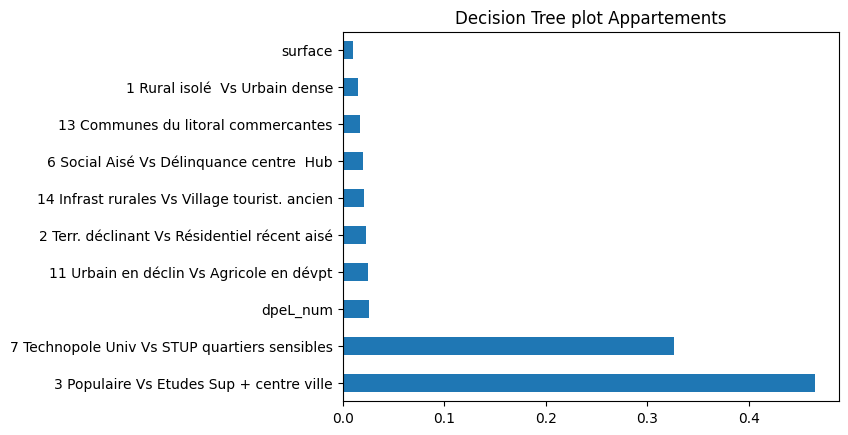

In [44]:
decision_tree = models["DecisionTreeRegressor"]
if DecisionTreeDisplay :
    feat_importances = pd.Series(
        decision_tree.feature_importances_, X_train.columns)
    feat_importances.nlargest(10).plot(kind='barh',title="Decision Tree plot Appartements")
    plt.show()

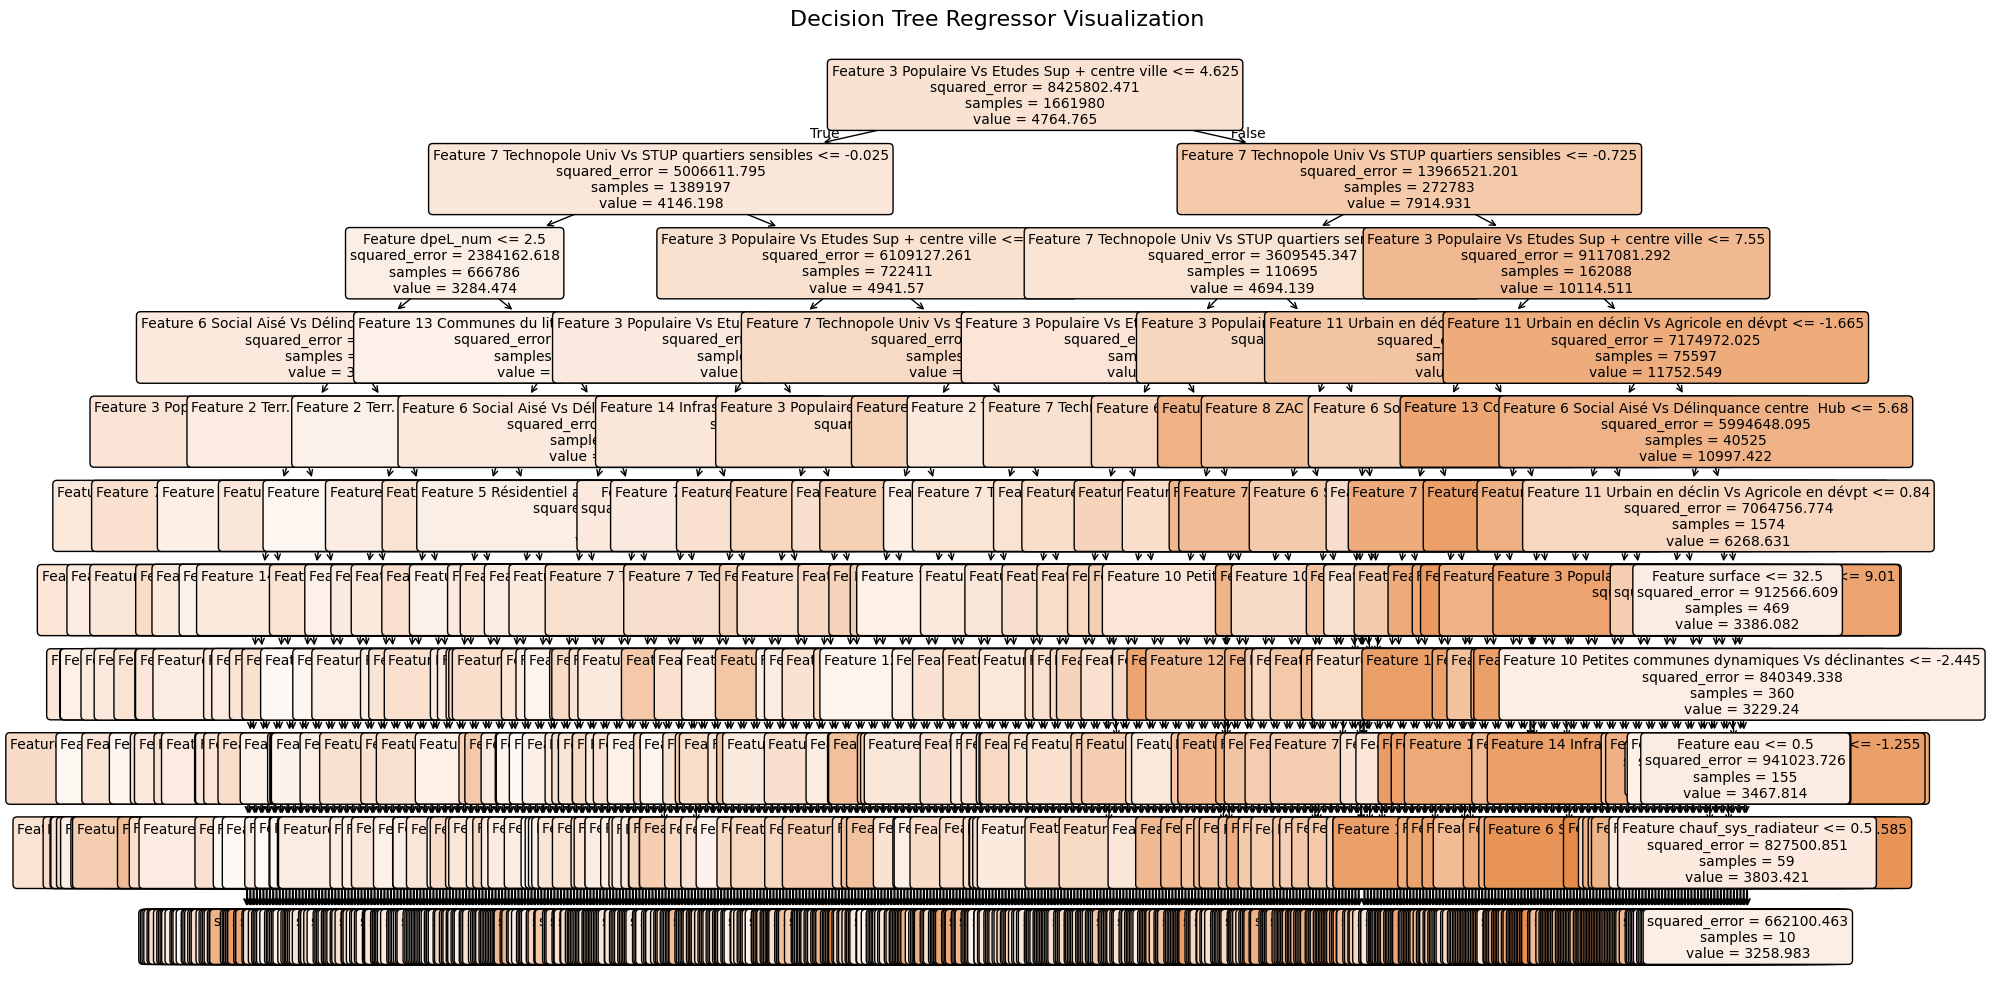

In [251]:
from sklearn.tree import plot_tree

if DecisionTreeDisplay :

    decision_tree = models["DecisionTreeRegressor"]
    # Visualize the decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(decision_tree, 
            feature_names=[f'Feature {name}' for name in X.columns],
            filled=True,
            rounded=True,
            fontsize=10)

    plt.title("Decision Tree Regressor Visualization", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

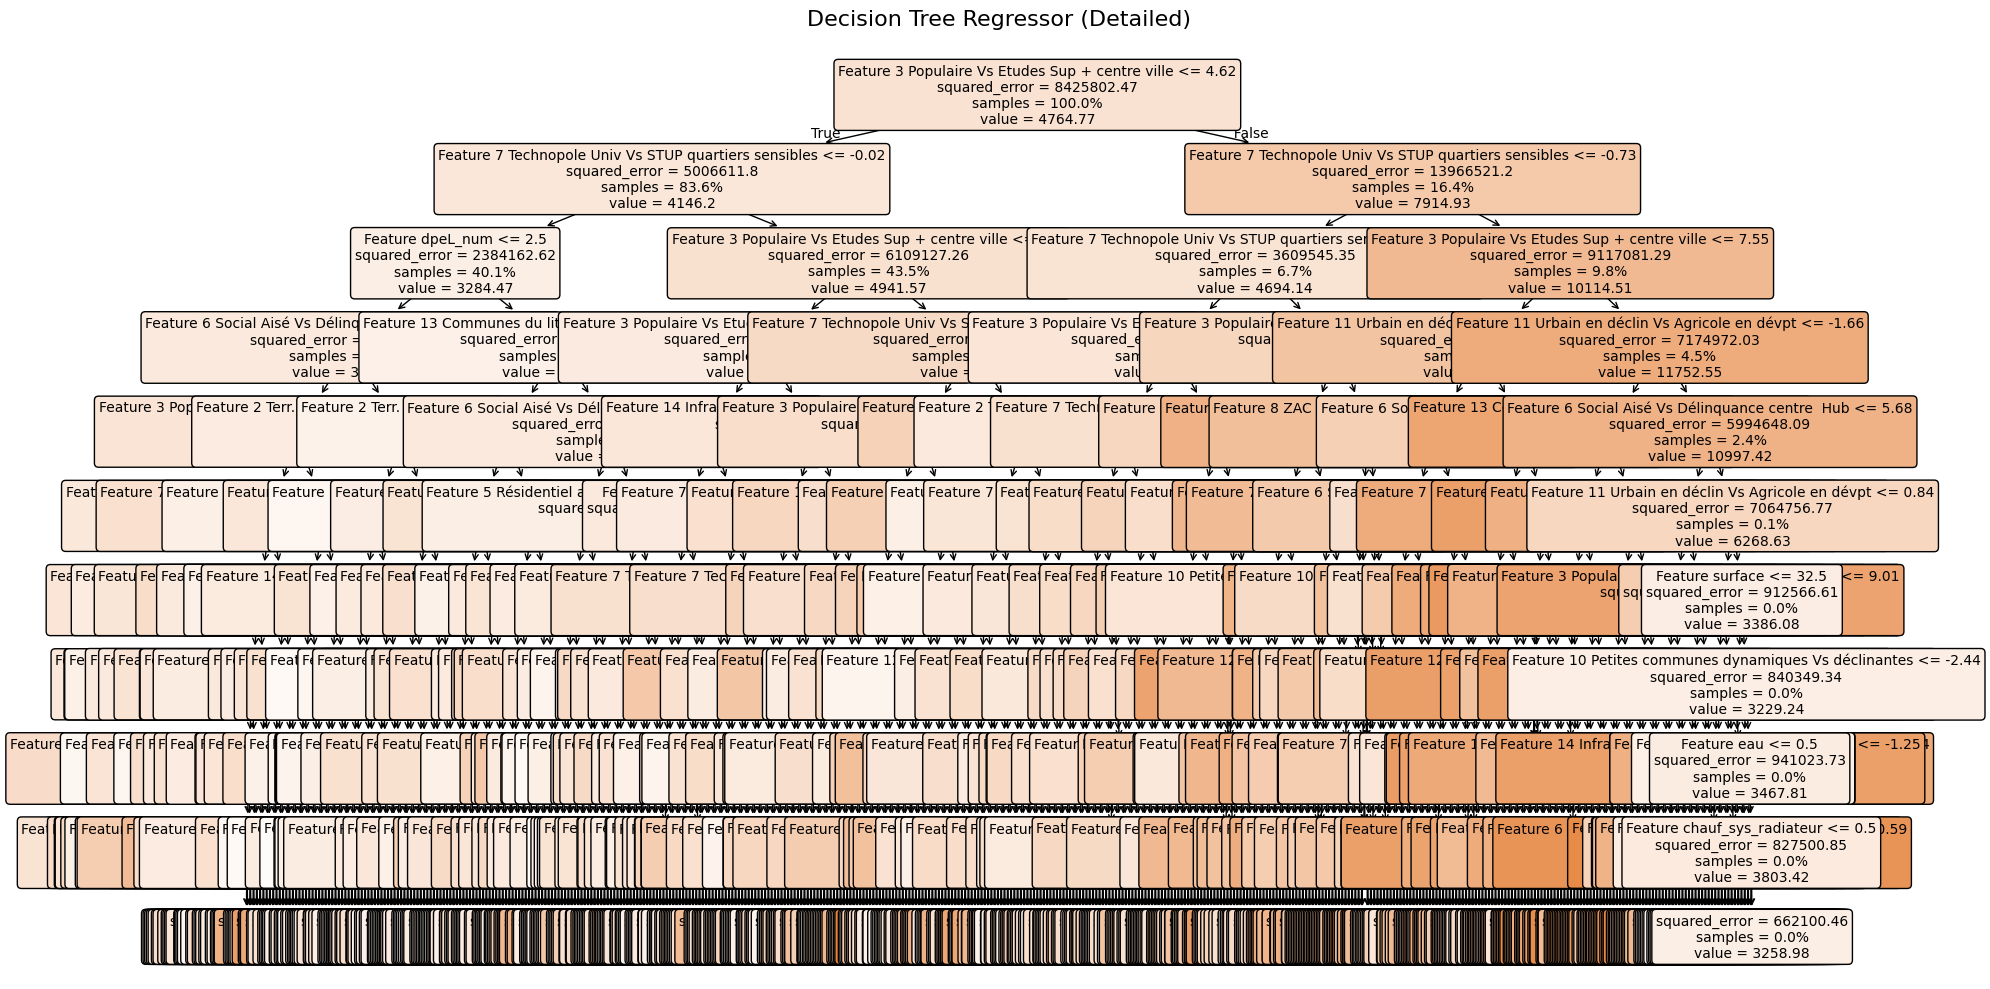

In [252]:
# Optional: More detailed visualization with additional parameters

if DecisionTreeDisplay :

    plt.figure(figsize=(20, 10))
    plot_tree(decision_tree, 
            feature_names=[f'Feature {name}' for name in X.columns],
            filled=True,
            rounded=True,
            fontsize=10,
            proportion=True,  # Show proportion of samples
            precision=2)      # Decimal precision

    plt.title("Decision Tree Regressor (Detailed)", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

# Shap interpretation of XGBRegressor

In [ ]:
def interpret_results_with_shap (model_name, model,X_test) :

    print ("Shap for model ",model_name)

    y_pred = model.predict(X_test)
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_test)

    print("="*60)
    print("SHAP INTERPRETATION GUIDE")
    print("="*60)
    print("""
    SHAP values explain how each feature contributes to predictions:
    - Positive SHAP value → feature pushes prediction HIGHER
    - Negative SHAP value → feature pushes prediction LOWER
    - Magnitude → strength of the feature's impact

    Base value: average model prediction across training data
    Prediction = Base value + sum of SHAP values for all features
    """)

    return explainer, shap_values, y_pred

def shap_summary_plot (shap_values,model_name) :
    # ==============================================================================
    # 1. SUMMARY PLOT - Feature Importance Overview
    # ==============================================================================
    print("\n1. SUMMARY PLOT (Feature Importance)")
    print("-" * 60)
    print("Shows:")
    print("  • Which features are most important globally")
    print("  • Distribution of SHAP values for each feature")
    print("  • Color: feature value (red=high, blue=low)")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, show=False)
    save_image(plt,filename="shap_summary_plot",modelname=model_name,dpi=300)
    plt.show()

def shap_bar_plot (shap_values,model_name) :
    # ==============================================================================
    # 2. BAR PLOT - Mean Absolute SHAP Values
    # ==============================================================================
    print("\n2. BAR PLOT (Mean Feature Importance)")
    print("-" * 60)
    print("Shows average impact magnitude of each feature")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    save_image(plt,"shap_bar_plot",modelname=model_name,dpi=300)
    plt.tight_layout()
    plt.show()

def shap_dependency_plot (shap_values,feature1,feature2,feature3,model_name) :
    # ==============================================================================
    # 3. DEPENDENCE PLOTS - Feature Effects
    # ==============================================================================
    print("\n3. DEPENDENCE PLOTS (Individual Feature Effects)")
    print("-" * 60)
    print("Shows how a feature's value affects predictions")
    print("Color shows interaction with another feature")

    # Plot for most important features
    important_features = [feature1, feature2, feature3]
    fig, axes = plt.subplots(1, 3, figsize=(15, 8))
    for idx, feature in enumerate(important_features):
        plt.sca(axes[idx])
        shap.dependence_plot(feature, shap_values.values, X_test, 
                            show=False, ax=axes[idx])
    save_image(plt,"shap_dependency_plot",modelname=model_name,dpi=300)
    plt.tight_layout()
    plt.show()

def shap_waterfall_plot (shap_values, y_pred,model_name) :

    # ==============================================================================
    # 4. WATERFALL PLOT - Single Prediction Explanation
    # ==============================================================================
    print("\n4. WATERFALL PLOT (Single Prediction Breakdown)")
    print("-" * 60)
    print("Shows how features contribute to ONE specific prediction")
    print("Reading from bottom to top:")
    print("  • Starts at base value (average prediction)")
    print("  • Each bar shows a feature's contribution")
    print("  • Ends at the final prediction")

    sample_idx = 0
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(shap_values[sample_idx], show=False)
    save_image(plt,"shap_waterfall_plot",modelname=model_name,dpi=300)
    plt.tight_layout()
    plt.show()

    # Print numerical breakdown
    print(f"\nPrediction breakdown for sample {sample_idx}:")
    print(f"Base value: {shap_values[sample_idx].base_values:.4f}")
    for i, feature in enumerate(X_test.columns):
        print(f"{feature:12s}: {shap_values[sample_idx].values[i]:+.4f} "
            f"(feature value: {X_test.iloc[sample_idx][feature]:.4f})")
    print(f"{'Final pred':12s}: {y_pred[sample_idx]:.4f}")
    print(f"{'Actual':12s}: {y_test.iloc[sample_idx]:.4f}")


def shap_force_plot ( explainer, shap_values, X_test,model_name) :
    # ==============================================================================
    # 5. FORCE PLOT - Multiple Predictions
    # ==============================================================================
    print("\n5. FORCE PLOT (Visual Push/Pull of Features)")
    print("-" * 60)
    print("Red bars push prediction higher, blue bars push lower")

    shap.initjs()

    display(shap.force_plot(explainer.expected_value, shap_values.values[0, :], X_test.iloc[0, :],show=False))
    
    plt.figure(figsize=(10, 6))
    fig  = shap.force_plot(explainer.expected_value, shap_values.values[70,:], X_test.iloc[70,:],show=False)
    save_image(fig,"shap_force_plot",modelname=model_name,dpi=300)
    plt.tight_layout()
    plt.show()


def shap_feature_interactions_plot (explainer, feature2,feature3,model_name) :
    # ==============================================================================
    # 6. FEATURE INTERACTIONS
    # ==============================================================================
    print("\n6. INTERACTION VALUES (Advanced)")
    print("-" * 60)
    print("Identifies which features interact with each other")

    # Calculate interaction values (can be slow for large datasets)
    shap_interaction_values = explainer.shap_interaction_values(X_test.iloc[:100])

    # Plot interaction for top feature
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        (feature2, feature3),
        shap_interaction_values,
        X_test.iloc[:100],
        show=False
    )
    plt.title(f"Interaction between {feature2} and {feature3}")
    save_image(plt,"shap_dependency_plot",modelname=model_name,dpi=300)
    plt.tight_layout()
    plt.show()



In [44]:
# Create SHAP explainer
if ShapDisplay :

    model_name = "XGBRegressor"
    model = models[model_name]
    explainer, shap_values, y_pred = interpret_results_with_shap ("XGBRegressor", model,X_test)


Shap for model  XGBRegressor
SHAP INTERPRETATION GUIDE

    SHAP values explain how each feature contributes to predictions:
    - Positive SHAP value → feature pushes prediction HIGHER
    - Negative SHAP value → feature pushes prediction LOWER
    - Magnitude → strength of the feature's impact

    Base value: average model prediction across training data
    Prediction = Base value + sum of SHAP values for all features
    


In [64]:
save_model_file (explainer,app_shap_explainer_file,model_name,compression_extension)

shap_force_plot(explainer,shap_values,X_test,model_name)

save model filename ../../data/immo_vis/shap-explainer-XGBRegressor.gz

5. FORCE PLOT (Visual Push/Pull of Features)
------------------------------------------------------------
Red bars push prediction higher, blue bars push lower


<Figure size 1000x600 with 0 Axes>


1. SUMMARY PLOT (Feature Importance)
------------------------------------------------------------
Shows:
  • Which features are most important globally
  • Distribution of SHAP values for each feature
  • Color: feature value (red=high, blue=low)


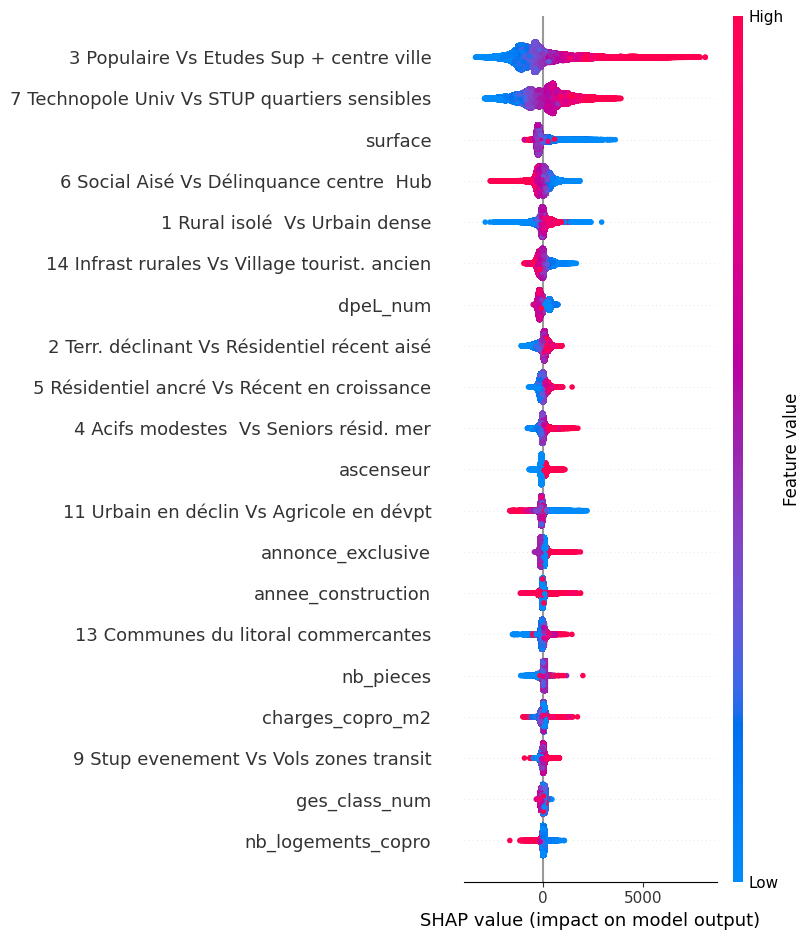


2. BAR PLOT (Mean Feature Importance)
------------------------------------------------------------
Shows average impact magnitude of each feature


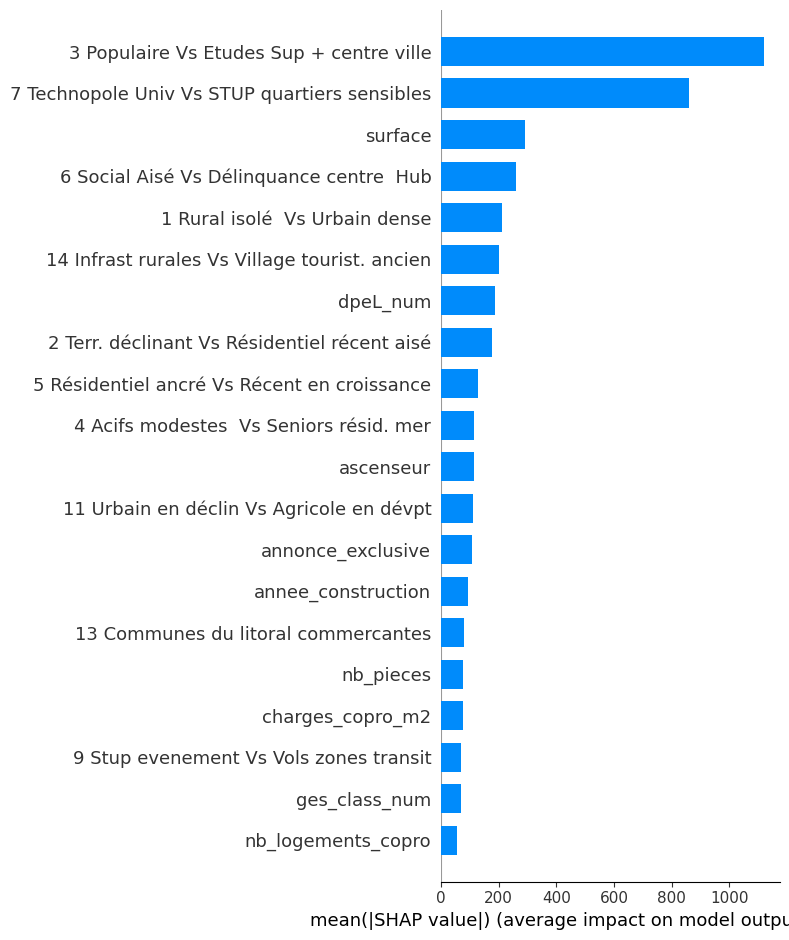


3. DEPENDENCE PLOTS (Individual Feature Effects)
------------------------------------------------------------
Shows how a feature's value affects predictions
Color shows interaction with another feature


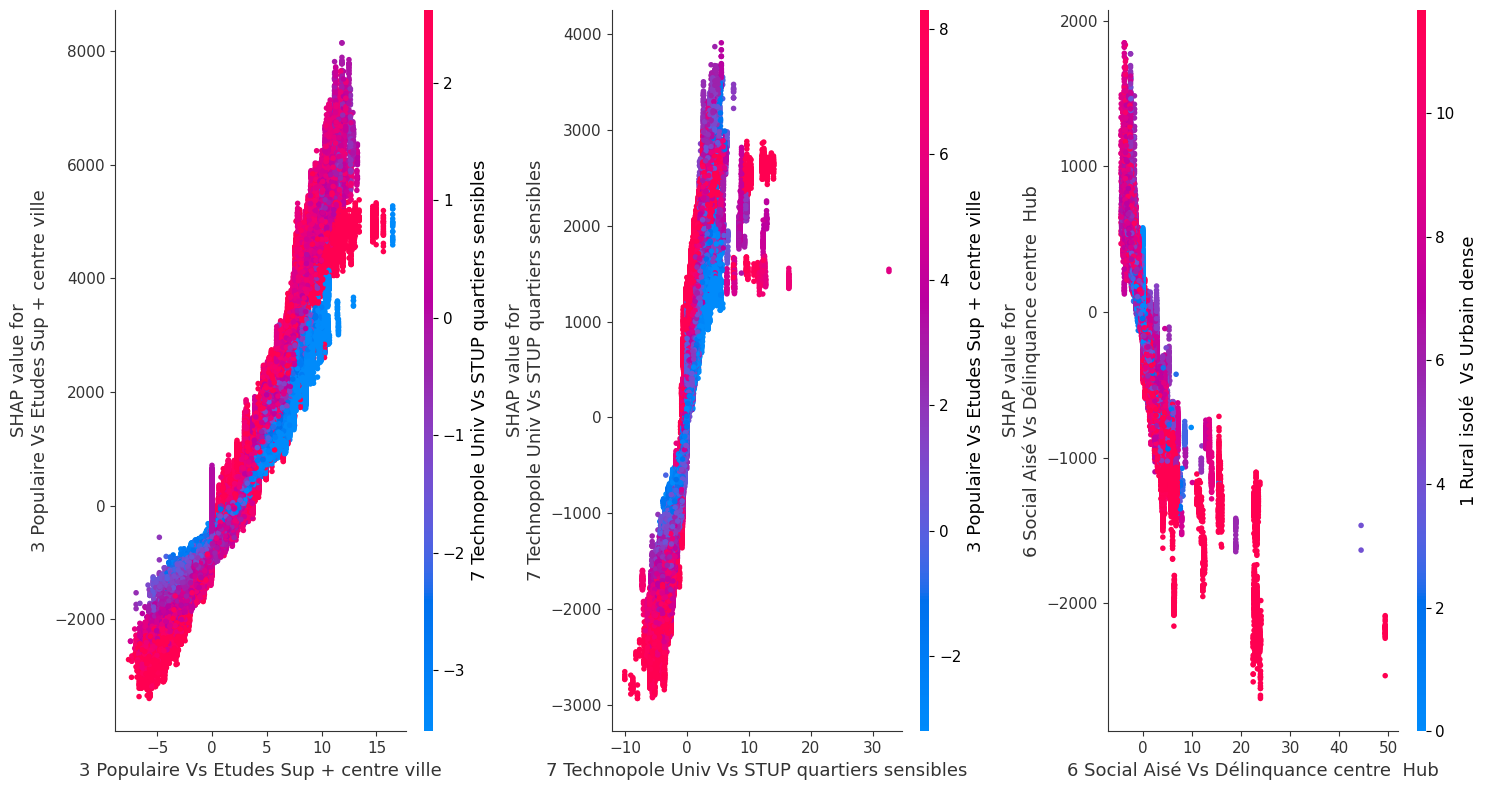


4. WATERFALL PLOT (Single Prediction Breakdown)
------------------------------------------------------------
Shows how features contribute to ONE specific prediction
Reading from bottom to top:
  • Starts at base value (average prediction)
  • Each bar shows a feature's contribution
  • Ends at the final prediction


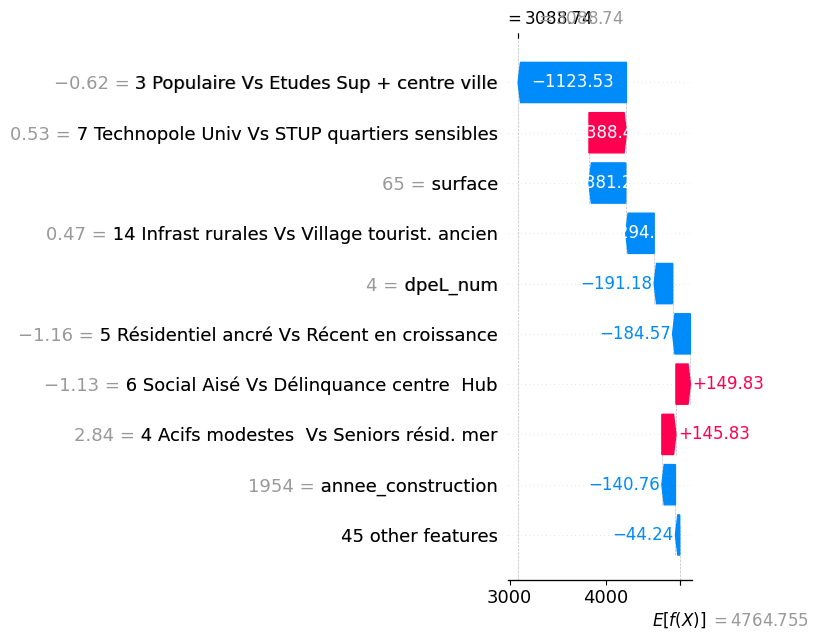


Prediction breakdown for sample 0:
Base value: 4764.7549
etage       : +10.7708 (feature value: 0.0000)
surface     : -381.2667 (feature value: 65.0000)
nb_pieces   : +4.8434 (feature value: 4.0000)
balcon      : +6.5442 (feature value: 0.0000)
eau         : +19.7705 (feature value: 1.0000)
bain        : +4.5640 (feature value: 0.0000)
annonce_exclusive: +36.7162 (feature value: 0.0000)
nb_etages   : +4.5801 (feature value: 4.0000)
places_parking: +21.6202 (feature value: 1.0000)
cave        : -32.7183 (feature value: 1.0000)
annee_construction: -140.7586 (feature value: 1954.0000)
nb_toilettes: -13.2590 (feature value: 1.0000)
nb_terraces : +0.0000 (feature value: 0.0000)
videophone  : -2.4451 (feature value: 0.0000)
porte_digicode: -16.7316 (feature value: 0.0000)
ascenseur   : -77.0789 (feature value: 0.0000)
nb_logements_copro: +33.1302 (feature value: 50.0000)
logement_neuf: +0.0658 (feature value: 0.0000)
charges_copro_m2: +3.8938 (feature value: 38.2957)
dpeL_num    : -191.1763


6. INTERACTION VALUES (Advanced)
------------------------------------------------------------
Identifies which features interact with each other


<Figure size 1000x600 with 0 Axes>

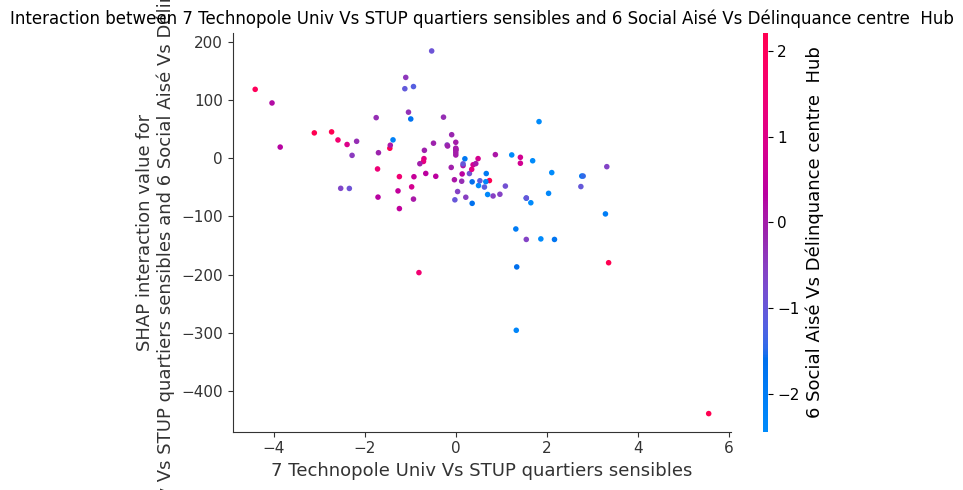

In [ ]:
if AddACP :
    feature1 = "PC3"
    feature2 = "PC7"
    feature3 = "PC6"

    feature1 = ACPS[feature1]
    feature2 = ACPS[feature2]
    feature3 = ACPS[feature3]
else :
    feature1 = "charges_copro_m2"
    feature2 = "porte_digicode"
    feature3 = "nb_etages"

shap_summary_plot(shap_values,model_name)

shap_bar_plot(shap_values,model_name)

shap_dependency_plot(shap_values,feature1,feature2,feature3,model_name)

shap_waterfall_plot(shap_values,y_pred,model_name)

shap_force_plot(explainer,shap_values,X_test,model_name)

shap_feature_interactions_plot(explainer,feature2,feature3,model_name)





3. DEPENDENCE PLOTS (Individual Feature Effects)
------------------------------------------------------------
Shows how a feature's value affects predictions
Color shows interaction with another feature


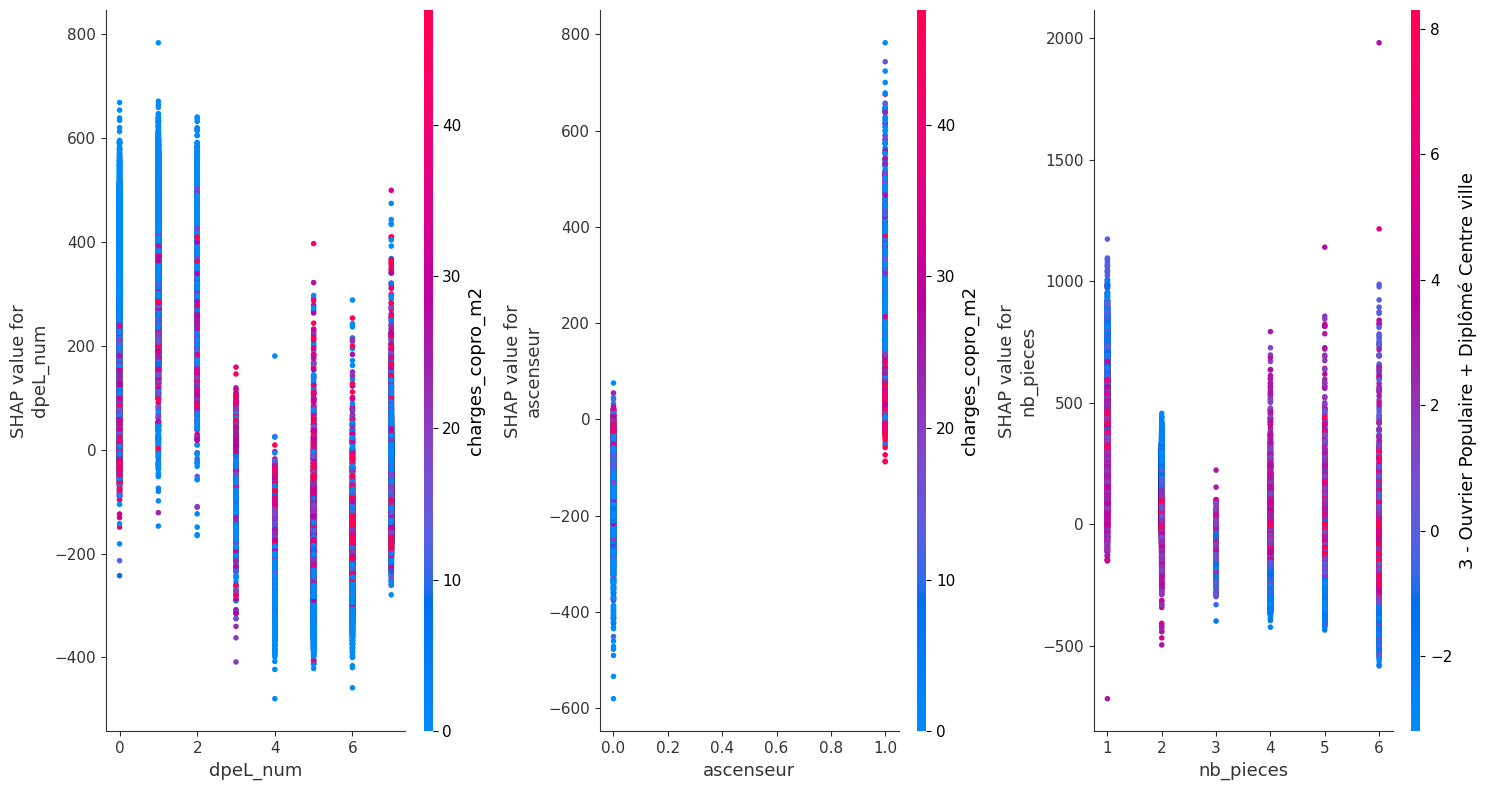

In [162]:
feature1 ="dpeL_num"
feature2 = "ascenseur"
feature3 = "nb_pieces"
shap_dependency_plot(shap_values,feature1,feature2,feature3)

In [ ]:
# ==============================================================================
# 3. DEPENDENCE PLOTS - Feature Effects
# ==============================================================================
print("\n3. DEPENDENCE PLOTS (Individual Feature Effects)")
print("-" * 60)
print("Shows how a feature's value affects predictions")
print("Color shows interaction with another feature")

feature1 = "surface"
feature2 = "PC3"
feature3 = "PC7"
# Plot for most important features
important_features = [feature1, feature2, feature3]
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
for idx, feature in enumerate(important_features):
    plt.sca(axes[idx])
    shap.dependence_plot(feature, shap_values.values, X_test, 
                        show=False, ax=axes[idx])
plt.tight_layout()
plt.show()
